# Samuel Watkins, 3032132676

# Homework 7: scikit-image

Due Tuesday Apr 10, 6pm

# Problem 1 - Counting objects

In class, we saw how to count the number of objects in a microscopy image.  Here, we will repeat that exercise, but make use of some of the algorithms in `scikit-image` to segment the image, and then to determine properties of the resulting objects.

As input, use the image `skimage.data.coins`.  Segment the image, and then calculate the area and eccentricity of each coin.

There are various ways to do this.  One would be:

1. Equalize the input image (see `skimage.exposure`)
2. Threshold the image (`skimage.filters.otsu`)
3. Remove objects touching the boundary (`skimage.segmentation.clear_border`)
4. Apply morphological closing (`skimage.morphology.closing`)
5. Remove small objects (`skimage.measure.regionprops`).
   Visualize the results if you want with `skimage.color.label2rgb`.
7. Calculate the area and eccentricity of each coin, and display the
   original image with this information on it (`matplotlib.pyplot.text` or `matplotlib.pyplot.annotate`)

In [1]:
from skimage.data import coins
from skimage.exposure import equalize_adapthist
from skimage.filters import threshold_otsu, threshold_triangle
from skimage.segmentation import clear_border
from skimage.morphology import closing, binary_opening, binary_closing,remove_small_objects,disk,reconstruction
from skimage.measure import regionprops, label, find_contours, ransac, EllipseModel
from skimage.color import label2rgb
from skimage.draw import ellipse_perimeter
from scipy.ndimage import binary_fill_holes
import matplotlib.pyplot as plt
import numpy as np

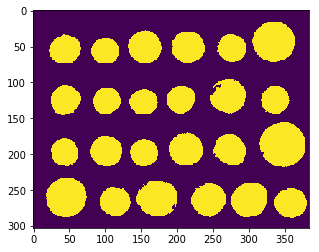

In [98]:
coins_eq = equalize_adapthist(coins())
coins_thresh = threshold_otsu(coins_eq)
coins_binary = coins_eq > coins_thresh
coins_borderless = clear_border(coins_binary)
coins_closed = closing(coins_borderless)
coin_props = regionprops(label(coins_closed))

region_sizes=np.array([prop["area"] for prop in coin_props])
size_thresh = threshold_otsu(region_sizes)
coins_largeobjs = remove_small_objects(coins_closed,min_size=size_thresh)
                                       
structure_el = disk(1)
seed = np.copy(coins_largeobjs)
seed[1:-1, 1:-1] = coins_largeobjs.max()
mask = coins_largeobjs
coins_noholes = reconstruction(seed, mask, selem=structure_el, method='erosion')

coin_props = regionprops(label(coins_noholes))
region_sizes=np.array([prop["area"] for prop in coin_props])
size_thresh= threshold_triangle(region_sizes)
coins_noholes = remove_small_objects(coins_noholes.astype("bool"),min_size=size_thresh)

contours = find_contours(coins_noholes,0)

coins_edges = np.zeros_like(coins_noholes,dtype=bool)
for contour in contours:
    for point in contour.astype("int"):
        coins_edges[point[0],point[1]] = True

coin_edges_props = regionprops(label(coins_edges))

bbox = np.array([prop["bbox"] for prop in coin_edges_props]).astype("int")

drawn_ellipses = np.zeros_like(coins_edges,dtype=bool)
eccentricities = np.zeros(len(coin_edges_props))
areas = np.zeros(len(coin_edges_props))

for ii,contour in enumerate(contours):
    model_robust, inliers = ransac(contour[:,::-1],EllipseModel,4,2)
    xc, yc, a, b, theta = model_robust.params
    cy, cx = ellipse_perimeter(int(yc), int(xc), int(a), int(b),orientation=theta-np.pi/2)
    drawn_ellipses[cy,cx] = True
    areas[ii] = np.pi*a*b
    if b<a:
        eccentricities[ii] = np.sqrt(1.0-b**2/a**2)
    else:
        eccentricities[ii] = np.sqrt(1.0-a**2/b**2)

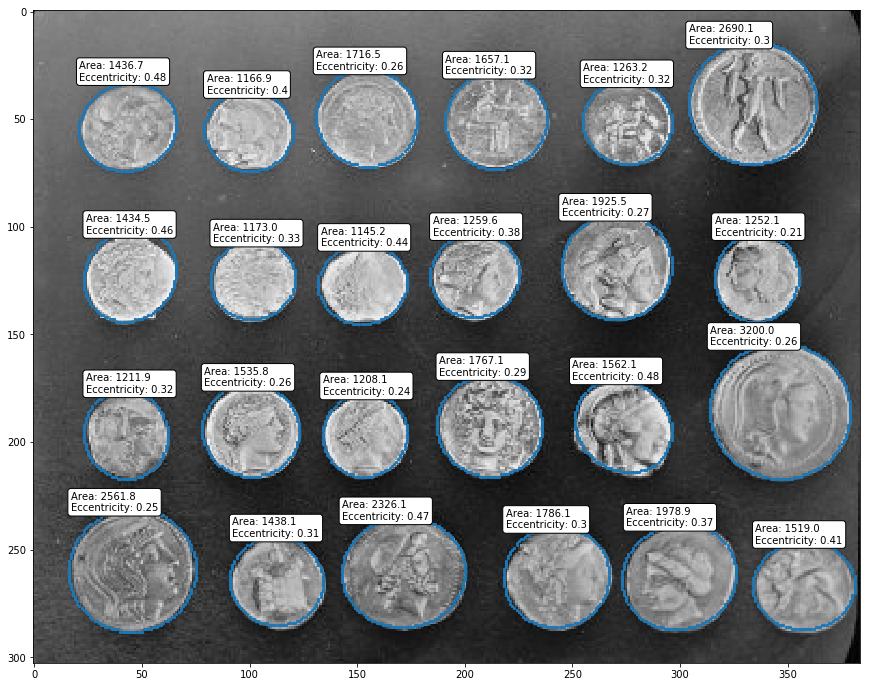

In [103]:
% matplotlib inline
fig,ax = plt.subplots(figsize=(20,12))
ax.imshow(coins(),cmap="gray")
x,y = np.where(drawn_ellipses)
ax.scatter(y,x,s=5)
# x,y = np.where(coins_edges)
# ax.scatter(y,x,s=5)

for ii,coords in enumerate(bbox):
    ax.annotate(f'Area: {round(areas[ii],1)}\nEccentricity: {round(eccentricities[ii],2)}',
                xy =[0,0], xytext=(coords[1], coords[0]),color="k",bbox=dict(boxstyle="round", fc="1"))

# Problem 2 - Panorama stitching

One of the scikit-image tutorials shows [how to do panorama stitching](https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/solutions/adv3_panorama-stitching-solution.ipynb).

Take 3 or 4 overlapping photos of your own, and use the procedure described to stitch your own panorama.

# scikit-image advanced panorama tutorial

Enhanced from the original demo as featured in [the scikit-image paper](https://peerj.com/articles/453/).

Multiple overlapping images of the same scene, combined into a single image, can yield amazing results. This tutorial will illustrate how to accomplish panorama stitching using scikit-image, from loading the images to cleverly stitching them together.

### First things first

Import NumPy and matplotlib, then define a utility function to compare multiple images

In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
def compare(*images, **kwargs):
    """
    Utility function to display images side by side.
    
    Parameters
    ----------
    image0, image1, image2, ... : ndarrray
        Images to display.
    labels : list
        Labels for the different images.
    """
    f, axes = plt.subplots(1, len(images), **kwargs)
    axes = np.array(axes, ndmin=1)
    
    labels = kwargs.pop('labels', None)
    if labels is None:
        labels = [''] * len(images)
    
    for n, (image, label) in enumerate(zip(images, labels)):
        axes[n].imshow(image, interpolation='nearest', cmap='gray')
        axes[n].set_title(label)
        axes[n].axis('off')
    
    f.tight_layout()

### Load data

The ``ImageCollection`` class provides an easy and efficient way to load and represent multiple images. Images in the ``ImageCollection`` are not only read from disk when accessed.

Load a series of images into an ``ImageCollection`` with a wildcard, as they share similar names. 

In [2]:
import skimage.io as io

pano_imgs = io.ImageCollection('*.jpg')

Inspect these images using the convenience function `compare()` defined earlier

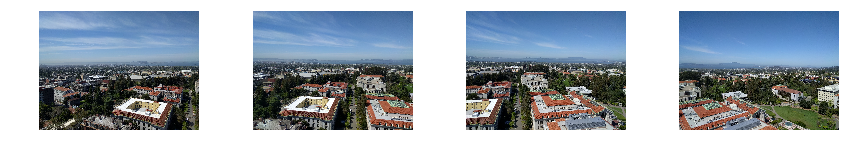

In [3]:
compare(*pano_imgs, figsize=(12, 10))

---

# 0. Pre-processing

This stage usually involves one or more of the following:
* Resizing, often downscaling with fixed aspect ratio
* Conversion to grayscale, as many feature descriptors are not defined for color images
* Cropping to region(s) of interest

For convenience our example data is already resized smaller, and we won't bother cropping. However, they are presently in color so coversion to grayscale with `skimage.color.rgb2gray` is appropriate.

In [4]:
from skimage.color import rgb2gray
from skimage.transform import rescale

panos = [rescale(rgb2gray(im),1/(4)**2) for im in pano_imgs]
del pano_imgs

/home/sam/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


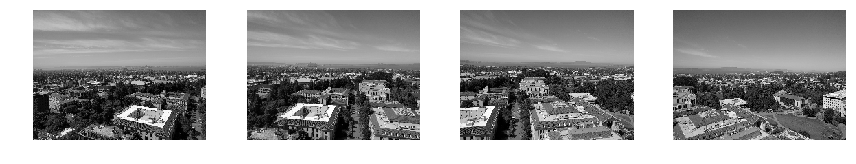

In [5]:
# View the results
compare(*panos, figsize=(12, 10))

# 1. Feature detection and matching

We need to estimate a projective transformation that relates these images together. The steps will be

1. Define one image as a _target_ or _destination_ image, which will remain anchored while the others are warped
2. Detect features in all three images
3. Match features from left and right images against the features in the center, anchored image.

In this three-shot series, the middle image `pano1` is the logical anchor point.

We detect "Oriented FAST and rotated BRIEF" (ORB) features in both images. 

**Note:** For efficiency, in this tutorial we're finding 800 keypoints. The results are good but small variations are expected. If you need a more robust estimate in practice, run multiple times and pick the best result _or_ generate additional keypoints.

In [6]:
from skimage.feature import ORB

# Initialize ORB
# 800 keypoints is large enough for robust results, 
# but low enough to run within a few seconds. 
orb = ORB(n_keypoints=1000, fast_threshold=0.05)

keypoints = []
descriptors = []

for pano in panos:
    # Detect keypoints in pano0
    orb.detect_and_extract(pano)
    keypoints.append(orb.keypoints)
    descriptors.append(orb.descriptors)

del orb

Match features from images 0 <-> 1 and 1 <-> 2.

In [7]:
from skimage.feature import match_descriptors

from itertools import combinations

combos = np.array(list(combinations(range(len(panos)),2)))
adj_combos_inds = combos[:,1]-combos[:,0]==1
adj_combos = combos[adj_combos_inds]

# Match descriptors between adjacent images and the center
matches = []
for combo in adj_combos:
    matches.append(match_descriptors(descriptors[combo[0]], descriptors[combo[1]], cross_check=True))

/home/sam/anaconda3/lib/python3.6/site-packages/skimage/feature/match.py:49: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  if np.issubdtype(descriptors1.dtype, np.bool):


Inspect these matched features side-by-side using the convenience function ``skimage.feature.plot_matches``. 

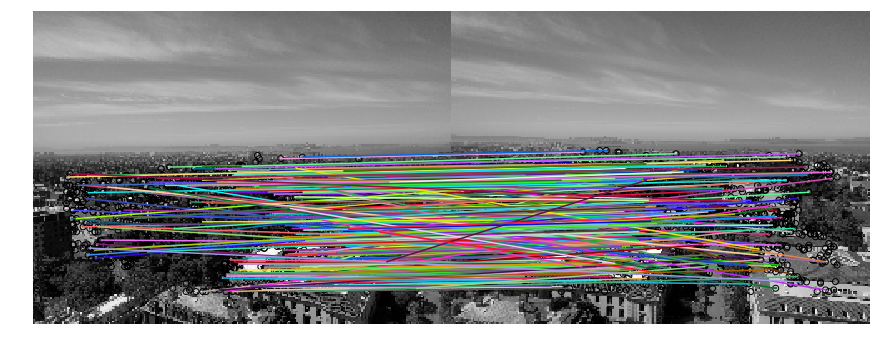

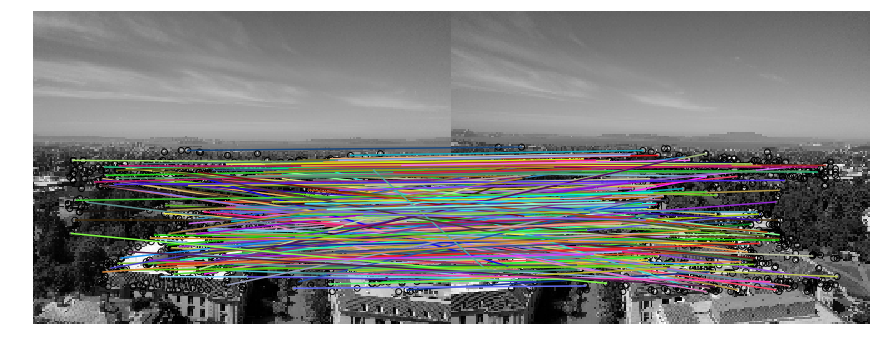

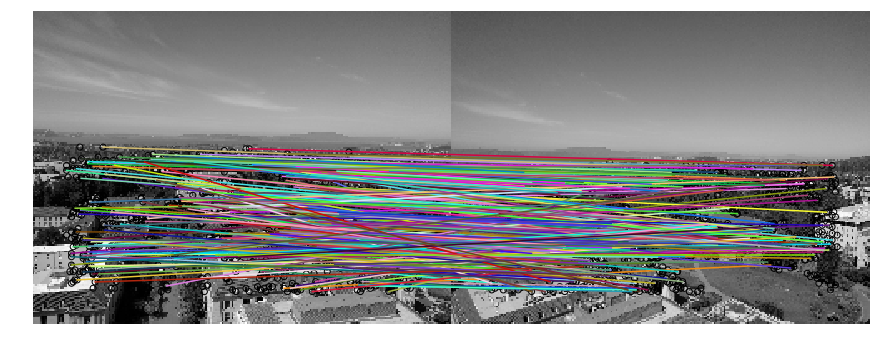

In [8]:
from skimage.feature import plot_matches


for ii,combo in enumerate(adj_combos):
    fig, ax = plt.subplots(1, 1, figsize=(15, 12))

    # Best match subset for pano0 -> pano1
    plot_matches(ax, panos[combo[0]], panos[combo[1]], keypoints[combo[0]], keypoints[combo[1]], matches[ii])
    ax.axis('off');

Most of these line up similarly, but it isn't perfect. There are a number of obvious outliers or false matches.

# 2. Transform estimation

To filter out the false matches, we apply RANdom SAmple Consensus (RANSAC), a powerful method of rejecting outliers available in ``skimage.transform.ransac``.  The transformation is estimated iteratively, based on randomly chosen subsets, finally selecting the model which corresponds best with the majority of matches.

We need to do this twice, once each for the transforms left -> center and right -> center.

In [9]:
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac

ref_img = 2 # always use the second image as the reference image (reference image should overlap with two images)

models_robust=[]
inliers=[]

for ii,combo in enumerate(adj_combos):
    # Select keypoints from source and target, with reference image determined by ref_img
    if combo[0]<ref_img:
        src = keypoints[combo[0]][matches[ii][:, 0]][:, ::-1]
        dst = keypoints[combo[1]][matches[ii][:, 1]][:, ::-1]
        model_robust, inlier_pts = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300)
        models_robust.append(model_robust)
        inliers.append(inlier_pts)
    else:
        src = keypoints[combo[1]][matches[ii][:, 1]][:, ::-1]
        dst = keypoints[combo[0]][matches[ii][:, 0]][:, ::-1]
        
        model_robust, inlier_pts = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300)
        models_robust.append(model_robust)
        inliers.append(inlier_pts)

The `inliers` returned from RANSAC select the best subset of matches. How do they look?

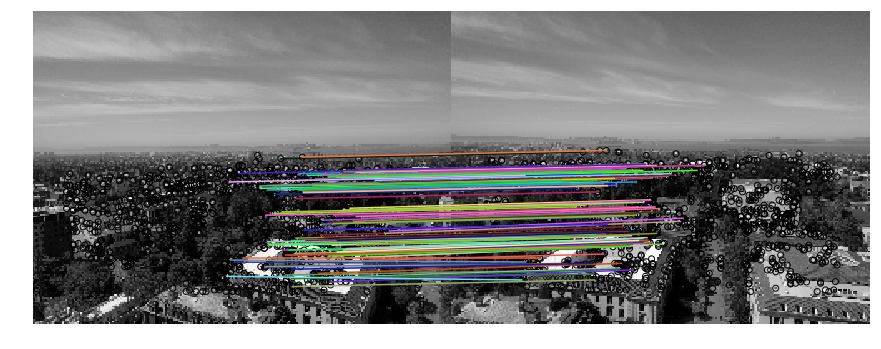

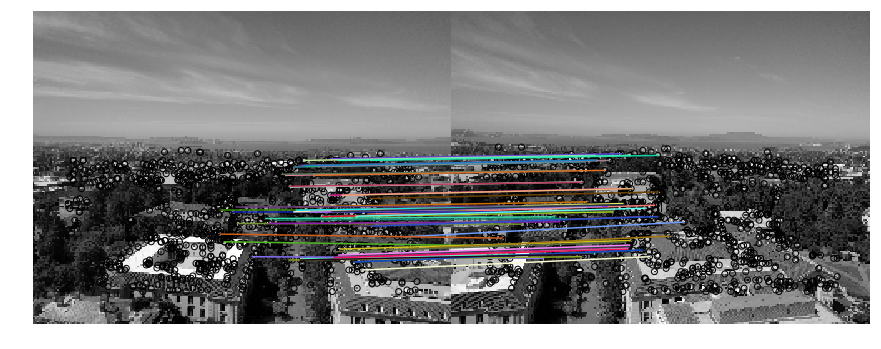

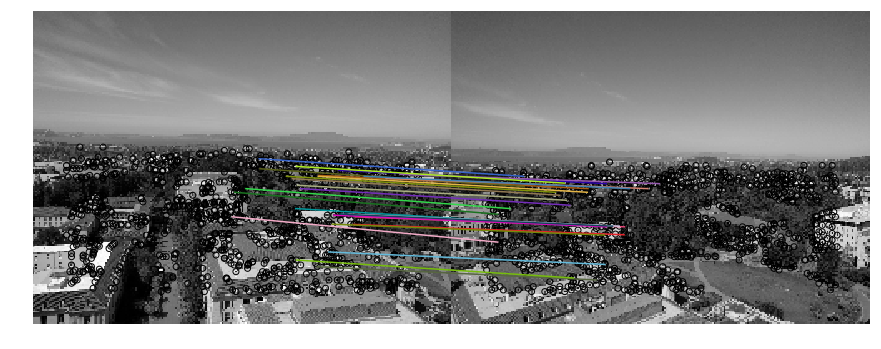

In [10]:
for ii,combo in enumerate(adj_combos):
    fig, ax = plt.subplots(1, 1, figsize=(15, 12))

    # Best match subset for pano0 -> pano1
    plot_matches(ax, panos[combo[0]], panos[combo[1]], keypoints[combo[0]], keypoints[combo[1]], matches[ii][inliers[ii]])
    ax.axis('off');

Most of the false matches are rejected!

---

# 3. Warping

Next, we produce the panorama itself. We must _warp_, or transform, two of the three images so they will properly align with the stationary image.

### Extent of output image
The first step is to find the shape of the output image to contain all three transformed images. To do this we consider the extents of all warped images.

In [11]:
from skimage.transform import SimilarityTransform

# del keypoints,matches,inliers,src,dst,descriptors

# Shape of middle image, our registration target
r, c = panos[ref_img].shape[:2]

# Note that transformations take coordinates in (x, y) format,
# not (row, column), in order to be consistent with most literature
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

warped_corners = []
for ii,combo in enumerate(adj_combos):
#     warped_corners.append(models_robust[ii](corners))
    # Warp the image corners to their new positions
    warped_corner = np.copy(corners)
    if combo[0]<ref_img:
        for iWarp in range(0,ii):
            warped_corner = models_robust[iWarp](warped_corner)
        warped_corners.append(warped_corner)
    else:
        for iWarp in range(ref_img,ii+1):
            warped_corner = models_robust[iWarp](warped_corner)
        warped_corners.append(warped_corner)

# Find the extents of both the reference image and the warped
# target image
warped_corners.append(corners)
all_corners = np.vstack(warped_corners)
# del warped_corners
# The overall output shape will be max - min
corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)
output_shape = (corner_max - corner_min)
del all_corners
# Ensure integer shape with np.ceil and dtype conversion
output_shape = np.ceil(output_shape[::-1]).astype(int)

### Apply estimated transforms

Warp the images with `skimage.transform.warp` according to the estimated models. A shift, or _translation_ is needed to place as our middle image in the middle - it isn't truly stationary.

Values outside the input images are initially set to -1 to distinguish the "background", which is identified for later use.

**Note:** ``warp`` takes the _inverse_ mapping as an input.

In [13]:
from skimage.transform import warp

# This in-plane offset is the only necessary transformation for the middle image
offset1 = SimilarityTransform(translation= -corner_min)

panos_warped = []
pano_masks = []
iCombo=0
for iPano,pano in enumerate(panos):
    if iPano<ref_img:
        pano_warped = np.copy(pano)
        for iWarp in range(iCombo,ref_img):
            if iWarp!=ref_img-1:
                transform = (models_robust[iWarp]).inverse
            else:
                transform = (models_robust[iWarp] + offset1).inverse
            pano_warped = warp(pano_warped, transform, order=3,
                                output_shape=output_shape, cval=-1)
        iCombo+=1
    elif iPano==ref_img:
        pano_warped = warp(pano,offset1.inverse,order=3,
                    output_shape=output_shape, cval=-1)
    else:
        pano_warped = np.copy(pano)
        for iWarp in range(iCombo,ref_img-1,-1):
            if iWarp!=ref_img:
                transform = (models_robust[iWarp]).inverse
            else:
                transform = (models_robust[iWarp] + offset1).inverse
                
            pano_warped = warp(pano_warped, transform, order=3,
                                output_shape=output_shape, cval=-1)
        iCombo+=1

    # Acquire the image mask for later use
    pano_mask = (pano_warped != -1)  # Mask == 1 inside image
    pano_warped[~pano_mask] = 0      # Return background values to 0
    
    panos_warped.append(pano_warped)
    pano_masks.append(pano_mask)




Inspect the warped images:

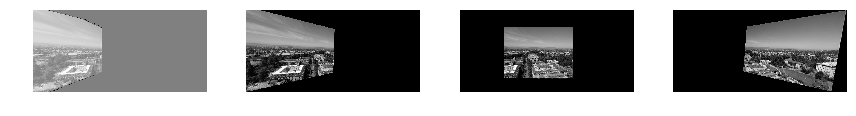

In [14]:
compare(*panos_warped, figsize=(12, 10));

---

# 4. Stitching images along a minimum-cost path

Let's step back a moment and consider: Is it even reasonable to blend pixels?

Take a look at a difference image, which is just one image subtracted from the other.

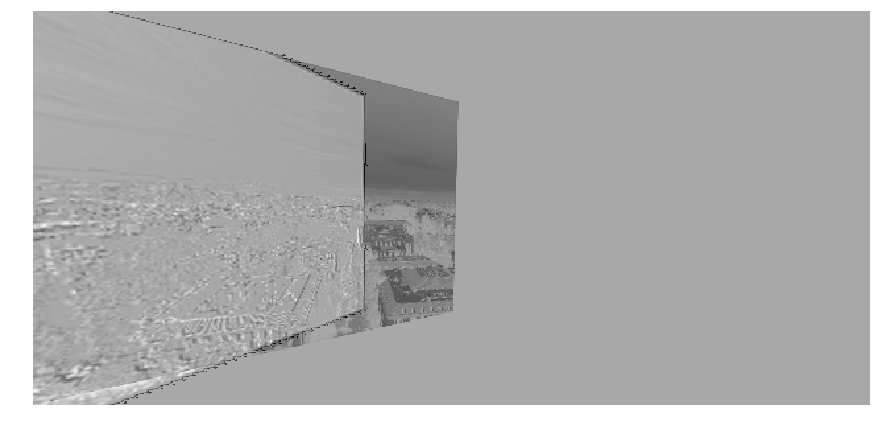

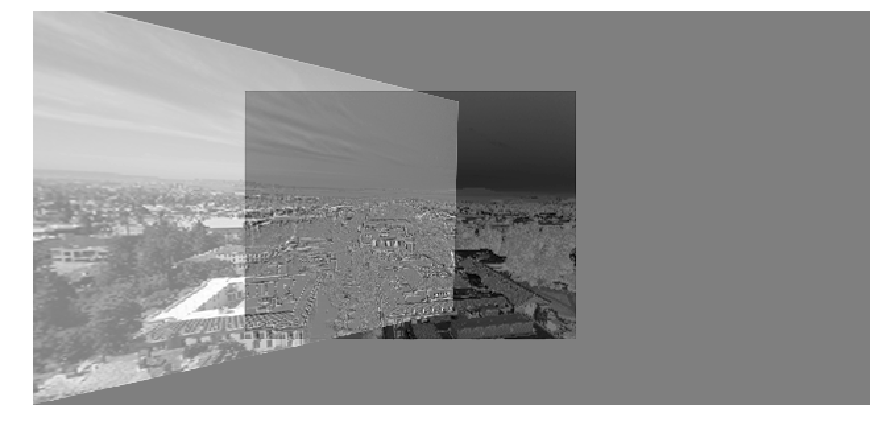

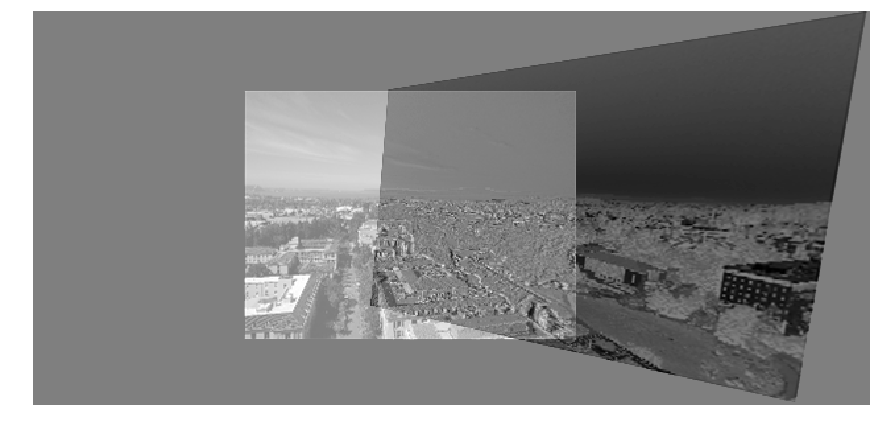

In [15]:

for ii,combo in enumerate(adj_combos):
    fig, ax = plt.subplots(figsize=(15,12))

    # Generate difference image and inspect it
    difference_image = panos_warped[combo[0]] - panos_warped[combo[1]]
    ax.imshow(difference_image, cmap='gray')

    ax.axis('off');
del difference_image

The surrounding flat gray is zero. _A perfect overlap would show no structure!_ 

Instead, the overlap region matches fairly well in the middle... but off to the sides where things start to look a little embossed, a simple average blurs the result. This caused the blurring in the previous, method (look again). _Unfortunately, this is almost always the case for panoramas!_

How can we fix this?

Let's attempt to find a vertical path through this difference image which stays as close to zero as possible. If we use that to build a mask, defining a transition between images, the result should appear _seamless_.

---

# Seamless image stitching with Minimum-Cost Paths and `skimage.graph`

Among other things, `skimage.graph` allows you to
* start at any point on an array
* find the path to any other point in the array
* the path found _minimizes_ the sum of values on the path.


The array is called a _cost array_, while the path found is a _minimum-cost path_ or **MCP**.

To accomplish this we need

* Starting and ending points for the path
* A cost array (a modified difference image)

This method is so powerful that, with a carefully constructed cost array, the seed points are essentially irrelevant. It just works!

### Define seed points

In [16]:
ymax = output_shape[1] - 1
xmax = output_shape[0] - 1

mask_pts = []

for combo in adj_combos:
    
    rightmostpixel = np.max(np.nonzero(np.any(panos_warped[combo[0]],axis=0))[0])
    leftmostpixel = np.min(np.nonzero(np.any(panos_warped[combo[1]],axis=0))[0])
    
    ystart = np.mean([rightmostpixel,leftmostpixel]).astype("int")
    
    mask_pt = [[0,    ystart],
                  [xmax, ystart]]
    mask_pts.append(mask_pt)

### Construct cost array

This utility function exists to give a "cost break" for paths from the edge to the overlap region.

We will visually explore the results shortly. Examine the code later - for now, just use it.

In [17]:
from skimage.measure import label

def generate_costs(diff_image, mask, vertical=True, gradient_cutoff=2.):
    """
    Ensures equal-cost paths from edges to region of interest.
    
    Parameters
    ----------
    diff_image : ndarray of floats
        Difference of two overlapping images.
    mask : ndarray of bools
        Mask representing the region of interest in ``diff_image``.
    vertical : bool
        Control operation orientation.
    gradient_cutoff : float
        Controls how far out of parallel lines can be to edges before
        correction is terminated. The default (2.) is good for most cases.
        
    Returns
    -------
    costs_arr : ndarray of floats
        Adjusted costs array, ready for use.
    """
    if vertical is not True:
        return tweak_costs(diff_image.T, mask.T, vertical=vertical,
                           gradient_cutoff=gradient_cutoff).T
    
    # Start with a high-cost array of 1's
    costs_arr = np.ones_like(diff_image)
    
    # Obtain extent of overlap
    row, col = mask.nonzero()
    cmin = col.min()
    cmax = col.max()

    # Label discrete regions
    cslice = slice(cmin, cmax + 1)
    labels = label(mask[:, cslice])
    
    # Find distance from edge to region
    upper = (labels == 0).sum(axis=0)
    lower = (labels == 2).sum(axis=0)
    
    # Reject areas of high change
    ugood = np.abs(np.gradient(upper)) < gradient_cutoff
    lgood = np.abs(np.gradient(lower)) < gradient_cutoff
    
    # Give areas slightly farther from edge a cost break
    costs_upper = np.ones_like(upper, dtype=np.float64)
    costs_lower = np.ones_like(lower, dtype=np.float64)
    costs_upper[ugood] = upper.min() / np.maximum(upper[ugood], 1)
    costs_lower[lgood] = lower.min() / np.maximum(lower[lgood], 1)
    
    # Expand from 1d back to 2d
    vdist = mask.shape[0]
    costs_upper = costs_upper[np.newaxis, :].repeat(vdist, axis=0)
    costs_lower = costs_lower[np.newaxis, :].repeat(vdist, axis=0)
    
    # Place these in output array
    costs_arr[:, cslice] = costs_upper * (labels == 0)
    costs_arr[:, cslice] +=  costs_lower * (labels == 2)
    
    # Finally, place the difference image
    costs_arr[mask] = diff_image[mask]
    
    return costs_arr

Use this function to generate the cost array.

In [18]:
from skimage.graph import route_through_array
from skimage.measure import label

masks = []
for ii,combo in enumerate(adj_combos):
    # Start with the absolute value of the difference image.
    # np.abs is necessary because we don't want negative costs!
    cost = generate_costs(np.abs(panos_warped[combo[0]] - panos_warped[combo[1]]),
                         pano_masks[combo[0]] & pano_masks[combo[1]])
    # Allow the path to "slide" along top and bottom edges to the optimal 
    # horizontal position by setting top and bottom edges to zero cost.
    cost[0,:] = 0
    cost[-1,:] = 0
#     for iMask in range(0,ii):
#         cost[masks[iMask] > 0] = 1
    if ii>0:
        cost[masks[ii-1]] = 1
    pts, _ = route_through_array(cost, mask_pts[ii][0], mask_pts[ii][1], fully_connected=True)
    # Convert list of lists to 2d coordinate array for easier indexing
    pts = np.array(pts)
    
    # Start with an array of zeros and place the path
    mask = np.zeros_like(panos_warped[combo[0]], dtype=np.uint8)
    mask[pts[:, 0], pts[:, 1]] = 1
    
    # Labeling starts with one at point (0, 0)
    if combo[0]<ref_img:
        mask = (label(mask, connectivity=1, background=-1) == 1)
    else:
        mask = (label(mask, connectivity=1, background=-1) == 3)
    masks.append(mask)

mask_ref = np.zeros_like(masks[0])
for mask in masks:
    mask_ref = mask_ref | mask
mask_ref = ~mask_ref.astype(bool)
# del pano_mask

Allow the path to "slide" along top and bottom edges to the optimal horizontal position by setting top and bottom edges to zero cost.

Our cost array now looks like this

The tweak we made with `generate_costs` is subtle but important. Can you see it?

### Find the minimum-cost path (MCP)

Use `skimage.graph.route_through_array` to find an optimal path through the cost array

Did it work?

That looks like a great seam to stitch these images together - the path looks very close to zero.

### Irregularities

Due to the random element in the RANSAC transform estimation, everyone will have a slightly different path. **Your path will look different from mine, and different from your neighbor's.** That's expected! _The awesome thing about MCP is that everyone just calculated the best possible path to stitch together their unique transforms!_

### Filling the mask

Turn that path into a mask, which will be 1 where we want the left image to show through and zero elsewhere. We need to fill the left side of the mask with ones over to our path.

**Note**: This is the inverse of NumPy masked array conventions (``numpy.ma``), which specify a negative mask (mask == bad/missing) rather than a positive mask as used here (mask == good/selected).

Place the path into a new, empty array.

Ensure the path appears as expected

Label the various contiguous regions in the image using `skimage.measure.label`

Looks great!

### Rinse and repeat

Apply the same principles to images 1 and 2: first, build the cost array

**Add an additional constraint this time**, to prevent this path crossing the prior one!

Check the result

Your results may look slightly different.

Compute the minimal cost path

Verify a reasonable result

Initialize the mask by placing the path in a new array

Fill the right side this time, again using `skimage.measure.label` - the label of interest is 2

### Final mask

The last mask for the middle image is one of exclusion - it will be displayed everywhere `mask0` and `mask2` are not.

Define a convenience function to place masks in alpha channels

In [19]:
def add_alpha(img, mask=None):
    """
    Adds a masked alpha channel to an image.
    
    Parameters
    ----------
    img : (M, N[, 3]) ndarray
        Image data, should be rank-2 or rank-3 with RGB channels
    mask : (M, N[, 3]) ndarray, optional
        Mask to be applied. If None, the alpha channel is added
        with full opacity assumed (1) at all locations.
    """
    from skimage.color import gray2rgb
    if mask is None:
        mask = np.ones_like(img)
        
    if img.ndim == 2:
        img = gray2rgb(img)
    
    return np.dstack((img, mask))

Obtain final, alpha blended individual images and inspect them

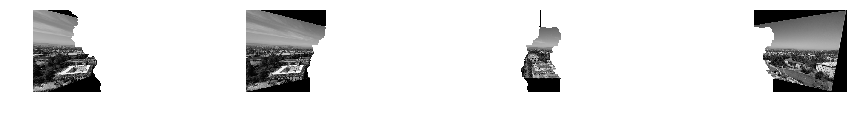

In [20]:
panos_final = []
iCombo=0
for iPano,pano_warped in enumerate(panos_warped):
    pano_warped[pano_warped<0]=0
    if iPano!=ref_img:
        panos_final.append(add_alpha(panos_warped[iPano],masks[iCombo]))
        iCombo+=1
    else:
        panos_final.append(add_alpha(panos_warped[ref_img],mask_ref))

# pano0_final = add_alpha(pano0_warped, mask0)
# pano1_final = add_alpha(pano1_warped, mask1)
# pano2_final = add_alpha(pano2_warped, mask2)

compare(*panos_final, figsize=(12, 12))
# del pano0_warped, pano1_warped, pano2_warped, mask0,mask1,mask2

What we have here is the world's most complicated and precisely-fitting jigsaw puzzle...

Plot all three together and view the results!

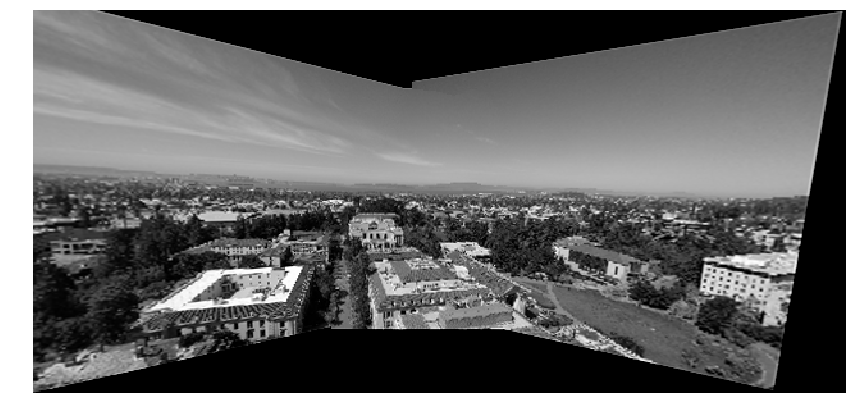

In [21]:
fig, ax = plt.subplots(figsize=(12, 12))

# This is a perfect combination, but matplotlib's interpolation
# makes it appear to have gaps. So we turn it off.
for pano in panos_final:
    ax.imshow(pano, interpolation='none')

fig.tight_layout()
ax.axis('off');

Fantastic! Without the black borders, you'd never know this was composed of separate images!

---

## Extra: Image Stacking

Reprocess one of the datasets from http://www.rawastrodata.com/.  See http://www.rawastrodata.com/pages/typesofimages.html for a description of the different kind of images.